# Module 4 - Reducing unfairness in learning algorithm applications 


### Assignment overview

In this assignment, you are tasked to create a classifer to predict the estimated income of individuals in the [Kaggle Adult Income Dataset](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset). This dataset is known to be biased towards certain groups. You will try some strategies to create a more fair classifier.

For this assignment, it is possible to work in **groups of up to 2 students**. 

### Group members
Leave blanks if group has less than 2 members:
- Student 1: Luna Gulec
- Student 2: Athena Wong


### Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:
1. Discuss the consequences of erroneous (biased) data on the training of learning algorithms and how it impacts its end users  
2. Discuss potential ethical implications in errors in feature selection, model selection
3. Define objective functions based on fairness metrics 
4. Describe strategies for reducing algorithmic bias 
5. Apply strategies to reduce unfairness in a predictive model trained on an unbalanced dataset 
6. Describe advantages and limitations of the strategies used to reduce unfairness in predictive models

### Libraries

Here are some libraries you will need for this assignment. 

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


### Dataset and EDA

The dataset you will use for this assignment is the [Kaggle Adult Income Dataset](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset). You may visit the source page for more information about this dataset.

The dataset includes 15 columns: 14 of them are demographics and other features to describe a person, and one (the target variable), is their income. The income variable is binary and has the two possible values `<=50K` or `>50K`.

Let's start by importing the dataset and taking a look (you are free to add other lines if you want more details):

In [2]:
df = pd.read_csv("adult.csv")
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Let's familiarize ourselves with the dataset through some basic exploratory data analysis (EDA).

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


When we use `info()` on the dataset, we see that there are no missing values, at least not as `NaNs`. But if you go back and check the first few row of the dataset, you may spot some "?".

In [4]:
# Let's see where the "?" are

cols_with_qmark = df.columns[df.apply(lambda col: col.astype(str).str.contains(r"\?").any())]
print(cols_with_qmark)

Index(['workclass', 'occupation', 'native.country'], dtype='object')


The "?" are in three categorical features. For clarity, let's swap them with the string "Unknown".

In [5]:
df = df.replace("?", "Unknown")

You may use this cell to check the distribution of the features `workclass`, `occupation`, and `native.country` (just swap the name of the column to check a different feature, or add more cells). As you can see, they are far from evenly distributed. We will not try to correct for this but it is good to be aware.

In [6]:
df["occupation"].value_counts()

occupation
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
Unknown              1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: count, dtype: int64

As mentioned in the introduction, this dataset is notoriously biased in the association between income and other demographic information, such as race and gender. Let's see how.

#### Question 1 
Create the following 3 bar charts:
- A global bar chart of the target variable
- A bar chart of the target variable divided by gender
- A bar chart of the target variable divided by race

Comment on the results. Is the target variable balanced? Is the target variable balanced across protected groups? What do you expect to be possible consequences of the distributions you have found?

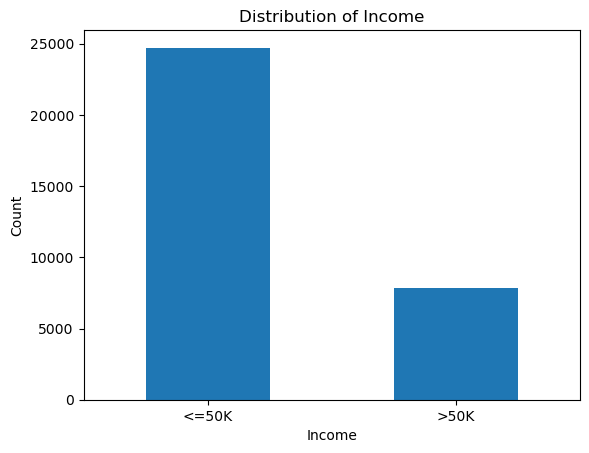

In [7]:
# A global bar chart of the target variable

import matplotlib.pyplot as plt

# global income distribution
income_counts = df["income"].value_counts()

# plot
plt.figure()
income_counts.plot(kind="bar")
plt.title("Distribution of Income")
plt.xlabel("Income")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

<Figure size 640x480 with 0 Axes>

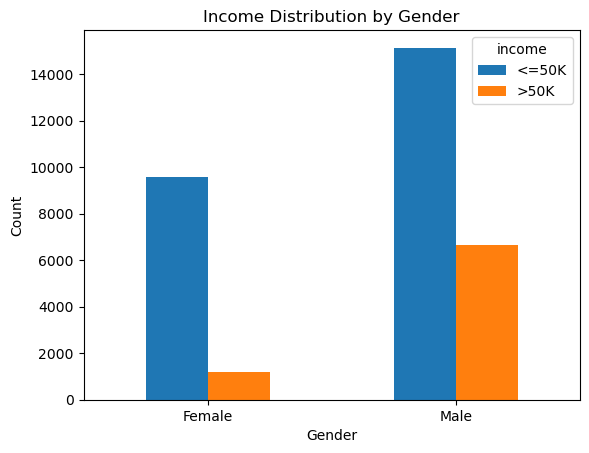

In [8]:
# A bar chart of the target variable divided by gender

# count combinations
gender_income = df.groupby(["sex", "income"]).size().unstack()

plt.figure()
gender_income.plot(kind="bar")
plt.title("Income Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

<Figure size 640x480 with 0 Axes>

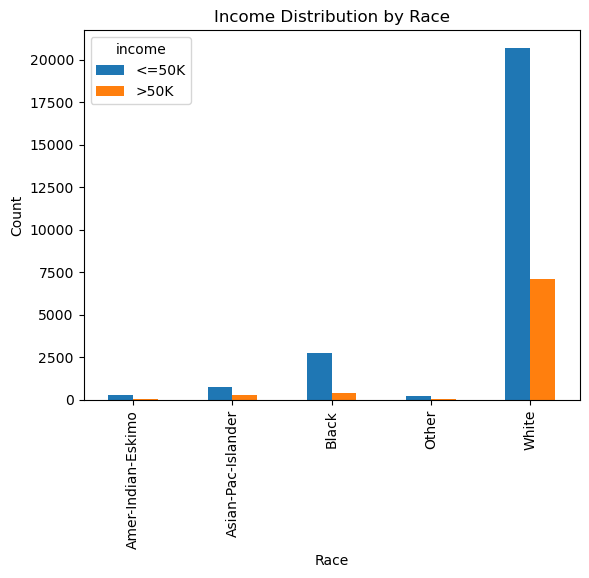

In [9]:
# A bar chart of the target variable divided by race

# count combinations
race_income = df.groupby(["race", "income"]).size().unstack()

plt.figure()
race_income.plot(kind="bar")
plt.title("Income Distribution by Race")
plt.xlabel("Race")
plt.ylabel("Count")
plt.show()

Before we start thinking of training classifiers on this detaset, let's split it in training and test set.

In [10]:
# Creating training and test sets and separating features and target
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)

X_train, y_train = (
    train_df.drop(columns=["income"]),
    train_df["income"],
)
X_test, y_test = (
    test_df.drop(columns=["income"]),
    test_df["income"],
)

We plan to again use the `aif360` library later in the assignment, so the dataset needs to be processed to fill any missing values and encode any non-numerical values (including the target).

In [11]:
# When working with aif360, the dataset has to be converted first, 
# and can not have missing or non-numerical values

# Run this cell to do the necessary dataset preprocessing (scaling, encoding of categorical features; 
# imputation is not needed as there are no missing values).

categorical_feats = ["workclass",
                    "education",
                    "marital.status",
                    "occupation",
                    "relationship",
                    "race",
                    "sex",
                    "native.country",
                    ]  # Apply one-hot encoding
numerical_feats = ["age",
                "fnlwgt",
                "education.num",
                "capital.gain",
                "capital.loss",
                "hours.per.week"
                ]  # Numerical - scale

target = "income"

ct = make_column_transformer(
    (StandardScaler(), numerical_feats),   # Scaling of numerical features
    (
        make_pipeline(OneHotEncoder(handle_unknown="ignore",drop="if_binary")),
        categorical_feats,
    ),  # OHE on categorical features
)

X_train_transformed = ct.fit_transform(X_train).toarray()

column_names = numerical_feats + list(
    ct.named_transformers_["pipeline"].get_feature_names_out(
        categorical_feats
    )
) 

X_test_transformed = ct.transform(X_test).toarray()

# Targets also need to be transformed
label_map = {">50K": 1, "<=50K": 0}

# Convert y
y_train_num = y_train.map(label_map)
y_test_num = y_test.map(label_map)

/opt/miniconda3/envs/dsci430/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [12]:
# You may use these lines to check the result
pd.DataFrame(X_train_transformed, columns=column_names)
pd.DataFrame(X_test_transformed, columns=column_names)

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Unknown,native.country_Vietnam,native.country_Yugoslavia
0,0.105685,0.493192,-0.418564,-0.148401,-0.216554,1.584432,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.188202,-0.043709,1.139035,-0.148401,-0.216554,-0.036804,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.849447,0.810989,-0.418564,-0.148401,-0.216554,-0.036804,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.648590,0.341002,0.749635,-0.148401,-0.216554,4.016284,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.996390,1.122599,-0.029164,-0.148401,-0.216554,0.368505,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9764,-1.143333,1.102258,-0.418564,-0.148401,-0.216554,-0.036804,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9765,0.252628,-1.569758,-0.029164,0.899669,-0.216554,-0.036804,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9766,0.913873,-0.486536,-0.418564,-0.148401,-0.216554,1.584432,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9767,0.766930,-0.759529,-0.029164,-0.148401,-0.216554,-0.685298,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### Question 2

Before moving further, it will be interesting to quantify the extent of the bias already existing in the dataset. We are going to focus on the different sexes included in our dataset (male and female). Answer the following questions:
1. What is the ratio of males making more than \\$50K to total males? This can be considered the existing *selection rate* for the priviledged group.
2. What is the ratio of females making more than \\$50K to total females? This can be considered the existing selection rate for the unpriviledged group.
3. What is the existing disparate impact ratio between these two groups? You may compute this value as the selection rate for the unpriviledged group divided by the selection rate for the priviledged.

In [13]:
# Some variables to get you started

male_df = test_df[test_df['sex'] == 'Male']
num_of_priviledged = male_df.shape[0]   # Number of males in the dataset; males are the priviledged group in this dataset

female_df = test_df[test_df['sex'] == 'Female']
num_of_unpriviledged = female_df.shape[0]   # Number of females in the dataset

In [17]:
# 1. the ratio of males making more than $50K to total males? (the existing selection rate for the priviledged group)

# selection rate = making >50K/total number in group

male_df = test_df[test_df["sex"] == "Male"]

num_of_privileged = male_df.shape[0] # gives the number of rows, i.e. how many males are in the test set

male_high_income = male_df[male_df["income"] == ">50K"].shape[0]

male_selection_rate = male_high_income / num_of_privileged

male_selection_rate

0.31091020533251607

In [18]:
# 2. the ratio of females making more than $50K to total females? (the existing selection rate for the unpriviledged group)

female_df = test_df[test_df["sex"] == "Female"]

num_of_unprivileged = female_df.shape[0]

female_high_income = female_df[female_df["income"] == ">50K"].shape[0]

female_selection_rate = female_high_income / num_of_unprivileged

female_selection_rate

0.10021584952204748

In [19]:
# 3. the existing disparate impact ratio between these two groups? 
# (the selection rate for the unpriviledged group divided by the selection rate for the priviledged)

disparate_impact = female_selection_rate / male_selection_rate
disparate_impact

0.3223305243868319

**Interpretation: selection rates**
- Males (privileged group): 0.31 = 31% earn >50K -> roughly 1 in 3 males in the test set is high-income.
- Females (unprivileged group): 0.10 = 10% earn >50K -> roughly 1 in 10 females in the test set is high-income.
- This already shows a strong imbalance by gender - males are much more likely to have high income.

**Interpretation: disparate impact**
- DI = 0.322 
- As DI < 1, the unprivileged group (females) is selected at a lower rate than the privileged group (males).
- DI < 0.8 -> potential discrimination / bias present
- Here: 0.322 < 0.8 -> this is a substantial disparity.

**Conclusion**
In the dataset, males are about three times as likely to earn more than $50K compared to females. The disparate impact ratio of 0.32 indicates significant gender-based imbalance. Any model trained on this data will likely reflect this bias, favoring males over females in predicting high-income outcomes.

### A biased classifier

We can expect that a classifier trained on this kind of data will show some problematic behaviors when assigning an individual to a predicted income level, if no attempt is made to make it more fair. Let's visualize this using a random forest classifier.

In [20]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0, max_depth = 19, n_estimators = 100).fit(X_train_transformed, y_train)

Let's evaluate the classifier, starting from the basics (accuracy). We'd still want to do it with `aif360`, for practice and consistency, so we need to convert the Pandas dataframe into a `BinaryLabelDataSet`. 

In [21]:
protected_attr = 'sex_Male'  

X_train_df = pd.DataFrame(X_train_transformed, columns=column_names, index=X_train.index)

protected_idx = X_train_df.columns.get_loc(protected_attr)

aif_train = BinaryLabelDataset(
    favorable_label=1,   # >50K
    unfavorable_label=0,    # <=50K
    df=pd.concat([X_train_df, y_train_num], axis=1),
    label_names=[y_train.name],
    protected_attribute_names=[protected_attr]
)

In [22]:
X_test_df = pd.DataFrame(X_test_transformed, columns=column_names, index=X_test.index)

protected_idx = X_test_df.columns.get_loc(protected_attr)

aif_test = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=pd.concat([X_test_df, y_test_num], axis=1),
    label_names=[y_test.name],
    protected_attribute_names=[protected_attr]
)

### Question 3

To evaluate the performance of this classifier, complete the following tasks:
1. Create a `BinaryLabelDataset` including the predictions of the Random Forest model on the test set.
2. Using a `ClassificationMetric` object, compute the following metrics:
    1. Accuracy
    2. Precision
    3. Recall
    4. F1 score (this will need to be computed manually using precision and recall)
    5. Disparate impact
    6. Accuracy for males
    7. Accuracy for females
    8. False positive rate disparity
    9. False negative rate disparity
3. Save all metrics in a dictionary (`results_dict`)
4. Evaluate the results, focusing on the visible differences in classification between males and females.
   

In [39]:
results_dict = {}

In [42]:
# 0. Convert Random Forest predictions to numeric (0/1)
y_test_pred_num = pd.Series(y_test_pred).map(label_map).values.reshape(-1, 1)

# 1. Create BinaryLabelDataset for predictions
aif_test_pred = aif_test.copy()
aif_test_pred.labels = y_test_pred_num

# 2. Create ClassificationMetric object and compute metrics
metric = ClassificationMetric(
    aif_test,          # true labels
    aif_test_pred,     # predicted labels
    unprivileged_groups=[{protected_attr: 0}],  # females
    privileged_groups=[{protected_attr: 1}],    # males
)

accuracy = metric.accuracy()
precision = metric.precision()
recall = metric.recall()
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
disparate_impact = metric.disparate_impact()

acc_male = metric.accuracy(privileged=True)
acc_female = metric.accuracy(privileged=False)
error_rate_diff = (1 - acc_female) - (1 - acc_male)

fpr_disparity = metric.false_positive_rate_difference()
fnr_disparity = metric.false_negative_rate_difference()

# 3. Save all metrics in results_dict
results_dict = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1_score,
    "disparate_impact": disparate_impact,
    "accuracy_male": acc_male,
    "accuracy_female": acc_female,
    "fpr_disparity": fpr_disparity,
    "fnr_disparity": fnr_disparity,
    "error_rate_diff": error_rate_diff
}

# convert to a single-row DataFrame for display 
df_results = pd.DataFrame([results_dict])
df_results

,accuracy,precision,recall,f1_score,disparate_impact,accuracy_male,accuracy_female,fpr_disparity,fnr_disparity,error_rate_diff
0,0.86406,0.797219,0.584537,0.67451,0.293966,0.829451,0.933703,-0.046751,0.089153,-0.104252


**Interpretation: Performance metrics**
- Accuracy: 0.864 -> the Random Forest correctly predicts income ~86% of the time.
- Precision: 0.797 -> of the individuals predicted to make >50K, ~80% are correct.
- Recall: 0.585 -> the model only identifies ~59% of all actual >50K earners.
- F1 score: 0.675 -> the balance between precision and recall is moderate.
- Therefore, the model is fairly accurate overall, but it has poor recall, errs on the side of "<=50K", and misses a significant portion of high earners (recall < precision), which is common in imbalanced datasets, and it makes sense because the "<=50K" is hte majority class.

**Interpretation: Disparate impact**
- Disparate impact: 0.294 -> this is much less than 1, indicating that females (unprivileged group) are much less likely to be predicted as high earners compared to males (privileged group).
- Therefore, there is a clear bias in the predictions against females, reflecting the bias already present in the dataset.

**Interpretation: Subgroup accuracies**
- Accuracy males: 0.829
- Accuracy females: 0.934
- Therefore, surprisingly, the model is more accurate for females. This can happen because the model predicts “<=50K” for most examples (class imbalance), and most females fall in that category. High accuracy here does not mean fair treatment — it mostly reflects the data distribution.

**Interpretation: Error rates**
- Error rate difference: -0.104 -> females have a slightly lower overall error rate than males, again due to class imbalance.
- Therefore, even though females have lower error rate, the model still under-predicts high-income females, consistent with the low disparate impact.

**Interpretation: False positive / false negative rate disparities**
- FPRD: -0.047 -> females have a slightly lower false positive rate than males. False positives (low earners predicted high) are slightly lower for females → fewer low-income females are misclassified as high earners.
- FNRD: 0.089 -> females have a slightly higher false negative rate than males. False negatives (high earners predicted low) affect females more than males → some high-income females are missed.

**Interpretation: Overall**
- The classifier reflects existing gender bias in the dataset.
- Males are more likely to be predicted as >50K earners (privileged group).
- Accuracy alone can be misleading in imbalanced and biased datasets — fairness metrics like disparate impact and FNRD are crucial for evaluation.
- Even though females have high accuracy, the model under-predicts high-income females, consistent with the low disparate impact.


By looking at the model feature importances, we can also find evidence that the model is not blind to the sex feature (as it should be), as this feature has a fairly high importance.

<Axes: >

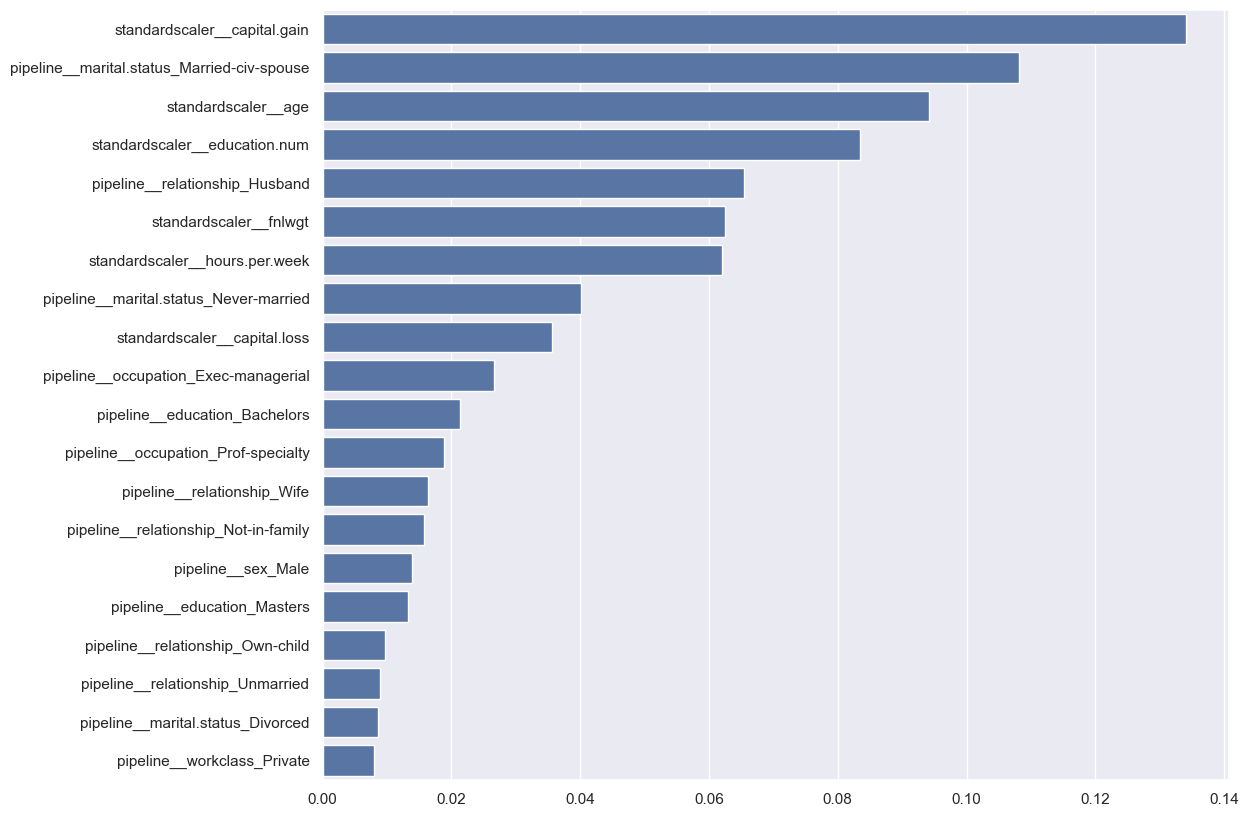

In [43]:
import seaborn as sns

feature_importances = clf.feature_importances_

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = ct.get_feature_names_out()[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# # Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(11.7,10)})
sns.barplot(x=sorted_importances[0:20], y=sorted_feature_names[0:20]) # Showing only top 20 features

## Debiasing techniques: dropping protected characteristics

### Question 4

A first idea to fix this issue could be dropping the sex feature (could be expanded to other protected characteristics) from our dataset before training the classifier. Complete the following tasks to see if this approach is helpful:

1. Remove `sex_Male` from the training set (code provided).
2. Retrain the classifier (code provided).
3. Using `aif360`, evaluate the new classifier (using all metrics we used to evaluate the original model). What can we tell from these results? Is the new classifier more balanced than the one that included the `sex_Male` feature?
4. Plot the feature importances of the new classifier. Can you spot other features that the model may have used as proxies for sex?

In [47]:
# 1. Remove sex_Male from X_train_transformed for re-training
X_train_df_drop = pd.DataFrame(X_train_transformed, columns=column_names, index=X_train.index)
X_train_df_drop = X_train_df.drop(columns='sex_Male')

# adding test too
X_test_drop = pd.DataFrame(X_test_transformed, columns=column_names).drop(columns='sex_Male')

In [45]:
# 2. Re-train the classifier without sex_Male
clf_drop = RandomForestClassifier(random_state=0, max_depth = 19, n_estimators = 100).fit(X_train_df_drop, y_train)

In [48]:
# 3. Predict and evaluate the new classifier using `aif360`
y_test_pred_drop = clf_drop.predict(X_test_drop)
aif_test_pred_drop = aif_test.copy()
aif_test_pred_drop.labels = pd.Series(y_test_pred_drop).map(label_map).values.reshape(-1,1)

metric_drop = ClassificationMetric(
    aif_test,
    aif_test_pred_drop,
    unprivileged_groups=[{protected_attr:0}],
    privileged_groups=[{protected_attr:1}]
)

In [49]:
# 4. Compute main metrics
results_drop_dict = {
    "accuracy": metric_drop.accuracy(),
    "disparate_impact": metric_drop.disparate_impact(),
    "accuracy_male": metric_drop.accuracy(privileged=True),
    "accuracy_female": metric_drop.accuracy(privileged=False),
}
pd.DataFrame([results_drop_dict])

,accuracy,disparate_impact,accuracy_male,accuracy_female
0,0.863548,0.286511,0.827766,0.935553


**Interpretation:**
- Accuracy: 0.864 -> almost the same as the original classifier (~0.864) -> dropping `sex_Mal`e` didn’t significantly reduce overall predictive performance.
- Disparate impact: 0.287 -> still much less than 1, and actually slightly lower than the original model (~0.294) -> removing the `sex_Male` feature did not meaningfully reduce bias. Females are still much less likely to be predicted as high earners compared to males.
- Accuracy males: 0.828, Accuracy females: 0.936 -> Females still have higher overall accuracy, but this is largely due to class imbalance - the model predicts most females as low-income. High female accuracy does not imply fairness; the model continues to under-predict high-income females.

Therefore, dropping the `sex_Male` feature slightly changes the classifier but does not eliminate bias. Overall accuracy remains high (~86%), and females still have higher accuracy due to class imbalance. However, the disparate impact is still very low (0.287), indicating that females are much less likely than males to be predicted as high earners, showing that the classifier is still biased. This shows that simply removing the protected feature does not fully prevent bias, as the model may rely on other features correlated with sex. Feature importance analysis can reveal such proxy variables.


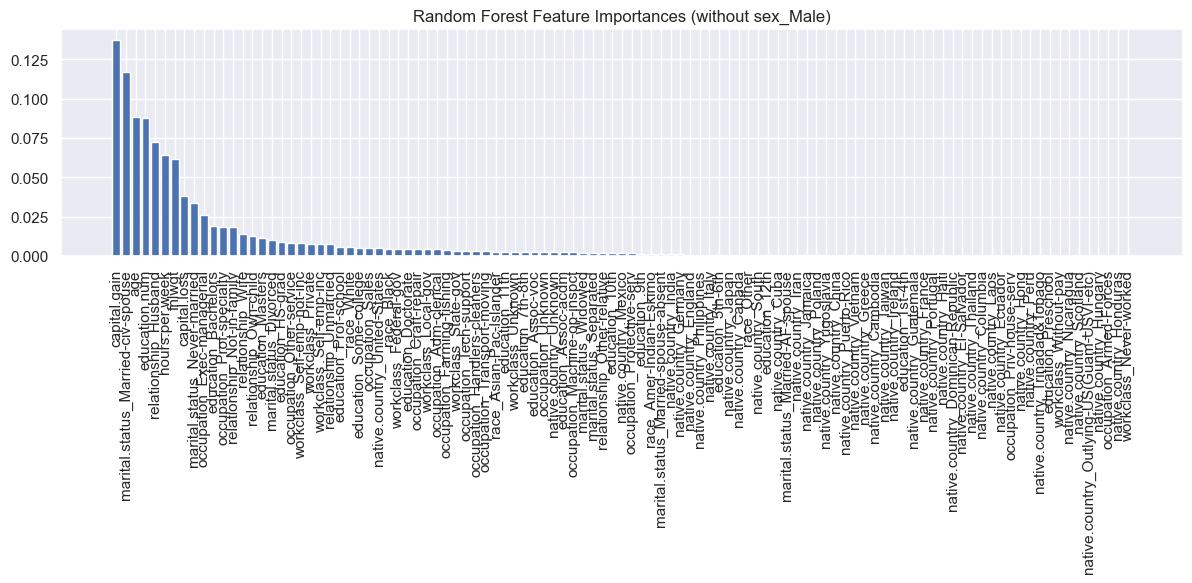

In [51]:
# 4. Plot the feature importances of the new classifier

# Feature importances
importances = clf_drop.feature_importances_
features = X_train_df_drop.columns

# Sort indices
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(12,6))
plt.title("Random Forest Feature Importances (without sex_Male)")
plt.bar(range(len(features)), importances[indices], align='center')
plt.xticks(range(len(features)), features[indices], rotation=90)
plt.tight_layout()
plt.show()

As we have seen, creating a fair classifier from a biased dataset is not trivial, because the bias has different ways to creep into the data and influence the model. We will now see some approaches that are explicitely designed to produce fairer results. 

## Preprocessing technique: reweighing

In our first approach, the correction happens *before* training, by assigning higher weights to the samples we believe to be at a disadvantage. We will do this using the [`Reweighing`](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.preprocessing.Reweighing.html) class in `aif360`. The reweighting technique used in `aif360` is based on: https://link.springer.com/article/10.1007/s10115-011-0463-8

Other techniques that can be used before training include changing some of the target labels, or resampling the dataset.

In [52]:
# Reweigh needs to learn from the training BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing

# Define privileged and unprivileged groups
privileged_groups = [{'sex_Male': 1}]  # Male
unprivileged_groups = [{'sex_Male': 0}]  # Non-Male

In [53]:
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
reweighed_train = RW.fit_transform(aif_train)
reweighed_test = RW.transform(aif_test)

In [54]:
# Comparing original vs. reweighed training datasets
display(aif_train.instance_weights[:5])
reweighed_train.instance_weights[:5]

# By looking at the training set, you will see that all these five samples are females, but only the first one has >50K as
# label. This sample is given a higher weight.

array([1., 1., 1., 1., 1.])

array([2.12214114, 0.85641167, 0.85641167, 0.85641167, 0.85641167])

In [55]:
# Extract features and labels from the reweighed dataset
X_train_weights = reweighed_train.features
y_train_weights = reweighed_train.labels.ravel()

# Extracting the reweighed sample weights
sample_weight = reweighed_train.instance_weights

X_test_weights = reweighed_test.features
y_test_weights = reweighed_test.labels.ravel()

In [56]:
# Re-training classifier
# This is the classic sklearn Random Forest Classifier, but we are using the additional parameter sample_weights
clf_weights = RandomForestClassifier(random_state=0, max_depth = 19, n_estimators = 100).fit(X_train_weights, y_train_weights, sample_weight=sample_weight)

### Question 5

Now that you have a new trained classifier, use `aif360` to evaluate it using all metrics used before. Add the results to `results_dict` for easy comparison. What can we tell from these results? Is the weighted classifier more balanced than the previous ones? Do we still see evidence of unequal behavior?

In [57]:
# 1. Convert predictions to a BinaryLabelDataset

y_test_pred_weights = clf_weights.predict(X_test_weights)

aif_test_pred_weights = aif_test.copy()
aif_test_pred_weights.labels = y_test_pred_weights.reshape(-1, 1)

In [58]:
# 2. Create a ClassificationMetric object and compute metrics
metric_weights = ClassificationMetric(
    aif_test,
    aif_test_pred_weights,
    unprivileged_groups=[{'sex_Male': 0}],
    privileged_groups=[{'sex_Male': 1}]
)

accuracy = metric_weights.accuracy()
precision = metric_weights.precision()
recall = metric_weights.recall()
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
disparate_impact = metric_weights.disparate_impact()
acc_male = metric_weights.accuracy(privileged=True)
acc_female = metric_weights.accuracy(privileged=False)
fpr_disparity = metric_weights.false_positive_rate_difference()
fnr_disparity = metric_weights.false_negative_rate_difference()
error_rate_diff = acc_female - acc_male

In [59]:
# 3. Save results

results_dict_weights = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1_score,
    "disparate_impact": disparate_impact,
    "accuracy_male": acc_male,
    "accuracy_female": acc_female,
    "fpr_disparity": fpr_disparity,
    "fnr_disparity": fnr_disparity,
    "error_rate_diff": error_rate_diff
}

df_results_weights = pd.DataFrame([results_dict_weights])
df_results_weights

,accuracy,precision,recall,f1_score,disparate_impact,accuracy_male,accuracy_female,fpr_disparity,fnr_disparity,error_rate_diff
0,0.859146,0.798171,0.556075,0.655483,0.450523,0.822709,0.93247,-0.018793,-0.079519,0.109761


**Interpretation**
- Accuracy: 0.859 -> slightly lower than the original classifier (0.864) and the one that dropped sex_Male (0.864) -> reweighing slightly reduced overall accuracy, which is expected when prioritizing fairness over raw predictive performance.
- Disparate impact: 0.451 -> higher than the original (0.294) and drop-sex classifier (0.287) -> the weighted classifier is more balanced between males and females — females are now predicted as high-income more fairly.
- Accuracy males: 0.823, Accuracy females: 0.932. Accuracy difference is smaller than before in terms of unfairness patterns, though females still have slightly higher overall accuracy -> the model treats males and females more equally in terms of prediction distribution.
- FPR disparity: -0.019 -> very small, almost balanced.
- FNR disparity: -0.080 -> significantly reduced compared to original (~0.089).
- False positives and false negatives are much more balanced across sexes, showing the reweighing successfully mitigated some of the unequal treatment.
- Error rate difference: 0.110 -> smaller than the original classifier, again showing a more balanced classifier.

Therefore, the reweighed classifier shows clear improvements in fairness - the model now gives females a better chance of being predicted as high-income without using the sex feature directly. Disparate impact increases from ~0.29 to ~0.45, indicating a more balanced chance for females to be predicted as high-income. False positive and false negative disparities are much smaller, and subgroup accuracies are closer to each other. While overall accuracy drops slightly, this pre-processing technique effectively reduces unequal behaviour compared to both the original and drop-sex classifiers, though some residual bias remains due to features correlated with sex.

## In-processing: Adversarial Debiasing

Another way to produce a more fair classifier is during training. In **adversarial debiasing**, a model is trained to perform the predictive task, while another model tries to "guess" the protected feature (sex, in our case) of a sample based on the prediction. The predicting model learns not to use the protected feature and even correct for it in order not to give away the answer to its adversary.

This idea was first described in [Mitigating Unwanted Biases with Adversarial Learning](https://dl.acm.org/doi/10.1145/3278721.3278779), by Zhang *et al.*.

Adversarial debiasing can easily be implemented in aif360. Here is the related documentation: https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.inprocessing.AdversarialDebiasing.html

Adversarial debiasing requires Tensorflow - ask the instructors if you encounter errors with running this model.

In [60]:
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

sess = tf.Session()

AD_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                        unprivileged_groups = unprivileged_groups,
                        scope_name='debiased_classifier',
                        debias=True,
                        sess=sess,
                        seed = 44)

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
AD_model.fit(aif_train)

In [ ]:
# Once we have a trained model, we can get its predictions and evaluate them.

# Conveniently, this predict already returns a BinaryLabelDataset

aif_test_pred_AD = AD_model.predict(aif_test)

### Question 6

Now that you have the predictions from adversarial debiasing, evaluate them using all metrics used before. Add the results to `results_dict` for easy comparison. What can we tell from these results? Is this classifier fairer than the ones we have seen so far? Do we still see evidence of unequal behavior?

## Post-processing: Equalized odds

Lastly, we can try to correct unfair predictions by acting on the final predictions themselves - a post-processing approach. We are going to use a post-processing algorithm called **equalized odds**. In `aif360`, this algorithm solves a linear program to determine the probability with which to
change output labels to optimize equalized odds. Here is the documentation: https://aif360.readthedocs.io/en/stable/modules/generated/aif360.algorithms.postprocessing.EqOddsPostprocessing.html#aif360.algorithms.postprocessing.EqOddsPostprocessing

For this technique, we can use the predictions of the original biased model, which are stored in `aif_test_pred`.

In [ ]:
from aif360.algorithms.postprocessing import EqOddsPostprocessing

# Creating the EqOddsPostprocessing object
eq_odds = EqOddsPostprocessing(
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups,
    seed=42
)

# Fit the post-processing algorithm to the test data
eq_odds.fit(aif_test, aif_test_pred)

In [ ]:
# The EqOddsPostprocessing can be used to make adjustments to the existing labels

aif_test_pred_odds = eq_odds.predict(aif_test_pred)   # already a BinaryLabelDataset

### Question 7

One more time, evaluate the new predictions using all metrics used before. Add the results to `results_dict` for easy comparison. What can we tell from these results? How do they compare to the ones we have seen so far? Do we still see evidence of unequal behavior?

If you are curious, you may try more debiasing techniques available in `aif360`. This short report offers a good summary of the available options, including the three we have explored: https://krvarshney.github.io/pubs/MahoneyVH2020.pdf

### Question 8 - Final evaluation

Let's assume that this dataset is being used to identify people who make more than \\$50K so that they cold be offered loans with competitive interest rates. In this scenario, which fairness metric should be prioritized?

Using **all the results collected so far**, write your recommendation about what model, in your opinion, should be employed for this application (300 words max). Make sure to include in your answer measures about how the two groups are treated, including how many in each group would be offered the loan.

**Summary of main take-aways:**
- Dropping protected characteristics does not help
- Adjusting weights helps but is the lest impactful approach
- Adversarial Debiasing is the most effective at approaching statistical parity
- Equalized odds is the most effective at balancing FNR and FPR
- Different methods may be preferred depending on the application

# Final thoughts

1) If you have completed this assignment in a group, please write a detailed description of how you divided the work and how you helped each other completing it:

2) Have you used ChatGPT or a similar Large Language Model (LLM) to complete this homework? Please describe how you used the tool. We will never deduct points for using LLMs for completing homework assignments, but this helps us understand how you are using the tool and advise you in case we believe you are using it incorrectly.

3) Have you struggled with some parts (or all) of this homework? Do you have pending questions you would like to ask? Write them down here!